In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import ast
import warnings
warnings.simplefilter("ignore")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/full_df_train.csv', skiprows = 1).drop(columns = ['0']).rename(columns = {'15' : 'rating'})
test_df = pd.read_csv('/content/drive/MyDrive/full_df_test.csv', skiprows = 1).drop(columns = ['0']).rename(columns = {'15' : 'rating'})

In [ ]:
!pip install simpletransformers
from simpletransformers.language_representation import RepresentationModel
from simpletransformers.config.model_args import ModelArgs

sentences = test_df['test'].to_list()


model_args = ModelArgs(n_gpu=256)

model = RepresentationModel(
        model_type="bert",
        model_name="bert-base-uncased",
        use_cuda=True,
        args=model_args
    )

test_sentence_vectors = model.encode_sentences(sentences, combine_strategy="mean")
print(test_sentence_vectors.shape)
np.save('test_embedings.npy', test_sentence_vectors)

In [ ]:
sentence_vectors = np.load('/content/drive/MyDrive/train_embedings.npy')
train_df = pd.DataFrame(sentence_vectors)
train_df['rating'] = df['rating']

X_train = train_df.drop(columns = ['rating'])
y_train = train_df['rating'].to_frame()

In [ ]:
test_sentence_vectors = np.load('/content/drive/MyDrive/test_embedings.npy')
df_test = pd.DataFrame(test_sentence_vectors)
df_test['rating'] = test_df['rating']

X_test = df_test.drop(columns = ['rating'])
y_test = df_test['rating'].to_frame()

In [ ]:
def rmse_test(model, model_name):
  tmp = df_test['rating'].to_frame()
  pred = model.predict(X_test)
  tmp['predicted'] = pred
  print(f'{model_name} rmse: {(np.diff(tmp.values) ** 2).mean() ** .5}')

In [ ]:
def accuracy_test(model, model_name):
  tmp = df_test['rating'].to_frame()
  pred = model.predict(X_test)
  tmp['predicted'] = pred
  tmp.rating = (tmp.rating >= 7).astype(int)
  tmp.predicted = (tmp.predicted >= 7).astype(int)

  print(f'{model_name} accuracy: {(tmp.rating == tmp.predicted).sum()/tmp.shape[0]}')

In [ ]:
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.naive_bayes import GaussianNB

clf = HistGradientBoostingClassifier().fit(X_train, y_train)
rmse_test(clf, 'GradientBoosting')
accuracy_test(clf, 'GradientBoosting')

rf = RandomForestClassifier().fit(X_train, y_train)
rmse_test(rf, 'RandomForest')
accuracy_test(rf, 'RandomForest')

lr = LogisticRegression(verbose = True).fit(X_train, y_train)
rmse_test(lr, 'LogRegression')
accuracy_test(lr, 'LogRegression')

gnb = GaussianNB().fit(X_train, y_train)
rmse_test(gnb, 'NaiveBayes')
accuracy_test(gnb, 'NaiveBayes')

GradientBoosting rmse: 3.158790907926639
GradientBoosting accuracy: 0.79536
RandomForest rmse: 3.5757292962415375
RandomForest accuracy: 0.76484
LogRegression rmse: 2.9400476186619833
LogRegression accuracy: 0.81724
NaiveBayes rmse: 3.568260080207159
NaiveBayes accuracy: 0.72024


In [ ]:
tmp = df_test['rating'].to_frame()
pred = lr.predict(X_test)
tmp['predicted'] = pred
tmp

,rating,predicted
0,10,10
1,7,7
2,9,8
3,8,10
4,8,8
...,...,...
24995,1,1
24996,1,1
24997,3,4
24998,3,3


<Axes: ylabel='Count'>

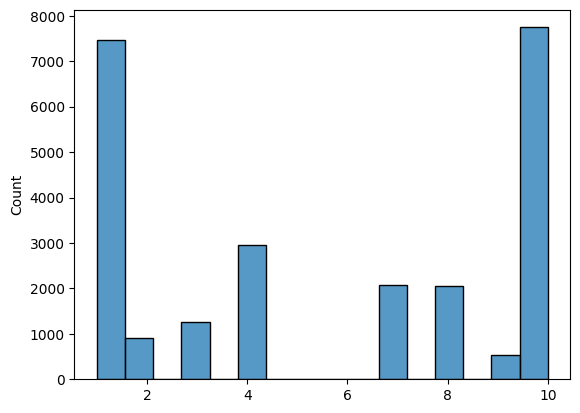

In [ ]:
sns.histplot(tmp.predicted.to_list())

In [ ]:
from joblib import dump, load
dump(clf, 'GradientBoosting.joblib')
#dump(lr, 'LogRegression.joblib')

['GradientBoosting.joblib']